In [ ]:
from google.colab import drive
drive.mount("/content/gdrive/")

Mounted at /content/gdrive/


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Jun  7 15:08:26 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torchvision import models, transforms, datasets
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import cv2
import random
import shutil

In [ ]:
!unzip /content/gdrive/MyDrive/pose_fall_data224x224.zip

Görüntülenen çıkış son 5000 satıra kısaltıldı.
  inflating: pose_fall_data224x224/train/non-fall/ars500176.png  
  inflating: pose_fall_data224x224/train/non-fall/ars500177.png  
  inflating: pose_fall_data224x224/train/non-fall/ars500178.png  
  inflating: pose_fall_data224x224/train/non-fall/ars500179.png  
  inflating: pose_fall_data224x224/train/non-fall/ars500180.png  
  inflating: pose_fall_data224x224/train/non-fall/ars500181.png  
  inflating: pose_fall_data224x224/train/non-fall/ars500182.png  
  inflating: pose_fall_data224x224/train/non-fall/ars500183.png  
  inflating: pose_fall_data224x224/train/non-fall/ars500184.png  
  inflating: pose_fall_data224x224/train/non-fall/ars500186.png  
  inflating: pose_fall_data224x224/train/non-fall/ars500187.png  
  inflating: pose_fall_data224x224/train/non-fall/ars500188.png  
  inflating: pose_fall_data224x224/train/non-fall/ars500189.png  
  inflating: pose_fall_data224x224/train/non-fall/ars500190.png  
  inflating: pose_fall_data22

In [ ]:
base_dir = "/content/gdrive/MyDrive/pose_fall_data/"
destination_dir = "pose_fall_data224x224/"

# Hedef dizini oluşturma
if not os.path.exists(destination_dir):
    os.makedirs(destination_dir)

# Train ve test dizinlerini al
train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")

# Her bir dizindeki sınıf dizinlerini al
class_dirs = ["fall", "non-fall"]

for class_dir in class_dirs:
    # Sınıf dizinlerinin yollarını oluştur
    train_class_path = os.path.join(train_dir, class_dir)
    test_class_path = os.path.join(test_dir, class_dir)

    # Hedef sınıf dizinlerinin yollarını oluştur
    dest_train_class_path = os.path.join(destination_dir, "train", class_dir)
    dest_test_class_path = os.path.join(destination_dir, "test", class_dir)

    # Hedef sınıf dizinlerini oluşturma
    if not os.path.exists(dest_train_class_path):
        os.makedirs(dest_train_class_path)
    if not os.path.exists(dest_test_class_path):
        os.makedirs(dest_test_class_path)

    # Train dizinindeki görüntüleri işleme
    train_files = os.listdir(train_class_path)
    for file_name in train_files:
        # Dosya yolunu oluşturma
        source_path = os.path.join(train_class_path, file_name)

        # Görüntüyü açma
        image = Image.open(source_path)

        # Yeniden boyutlandırma
        resized_image = image.resize((224, 224))

        # Yeni dosya yolunu oluşturma
        destination_path = os.path.join(dest_train_class_path, file_name)

        # Yeniden boyutlandırılmış görüntüyü kaydetme
        resized_image.save(destination_path)

        print(f"{file_name} başarıyla kaydedildi.")

    # Test dizinindeki görüntüleri işleme
    test_files = os.listdir(test_class_path)
    for file_name in test_files:
        # Dosya yolunu oluşturma
        source_path = os.path.join(test_class_path, file_name)

        # Görüntüyü açma
        image = Image.open(source_path)

        # Yeniden boyutlandırma
        resized_image = image.resize((224, 224))

        # Yeni dosya yolunu oluşturma
        destination_path = os.path.join(dest_test_class_path, file_name)

        # Yeniden boyutlandırılmış görüntüyü kaydetme
        resized_image.save(destination_path)

        print(f"{file_name} başarıyla kaydedildi.")

print("Tüm görüntüler başarıyla işlendi ve kaydedildi.")

In [ ]:
data_dir = '/content/pose_fall_data224x224'
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')

os.makedirs(val_dir, exist_ok=True)

class_names = ['fall', 'non-fall']

for class_name in class_names:
    os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)

for class_name in class_names:
    class_dir = os.path.join(train_dir, class_name)
    image_files = os.listdir(class_dir)
    random.shuffle(image_files)

    val_percentage = 0.2
    val_size = int(len(image_files) * val_percentage)
    val_files = image_files[:val_size]

    for val_file in val_files:
        src = os.path.join(class_dir, val_file)
        dst = os.path.join(val_dir, class_name, val_file)
        shutil.move(src, dst)

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {
    'train': datasets.ImageFolder(train_dir, data_transforms['train']),
    'val': datasets.ImageFolder(val_dir, data_transforms['val'])
}

dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=8, shuffle=True, num_workers=2),
    'val': DataLoader(image_datasets['val'], batch_size=8, shuffle=True, num_workers=2)
}

dataset_sizes = {
    'train': len(image_datasets['train']),
    'val': len(image_datasets['val'])
}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [ ]:
model = models.vgg16(pretrained=True)

print("Önceki Classifier Hali:")
print(model.classifier)

# Modelin sınıflandırma katmanları
classifier = list(model.classifier.children())

# Son üç katmanı kaldırma
classifier = classifier[:-3]

# Yeni sınıflandırma katmanını oluşturma
new_classifier = nn.Sequential(*classifier)

# Modelin sınıflandırma katmanını güncelleme
model.classifier = new_classifier

# Son sınıflandırma katmanından sonra gelen parametreleri dondurma
for param in model.features.parameters():
    param.requires_grad = False

print("Sonraki Classifier Hali:")
print(model.classifier)

# Modeli GPU'ya taşıma
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)


In [ ]:
model = models.vgg16(pretrained=True)

print("Önceki Classifier Hali:")
print(model.classifier)

# Modelin sınıflandırma katmanlarını alın
classifier = list(model.classifier.children())

# Son üç tam bağlantılı katmanı kaldırın
classifier = classifier[:-3]

# Yeni sınıflandırma katmanını oluşturun
new_classifier = nn.Sequential(*classifier)

# Modelin sınıflandırma katmanını güncelleyin
model.classifier = new_classifier

# Son sınıflandırma katmanından sonra gelen parametreleri dondurucu yapın
for param in model.features.parameters():
    param.requires_grad = False

print("Sonraki Classifier Hali:")
print(model.classifier)

# Modeli GPU'ya taşıma
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:04<00:00, 133MB/s]


Önceki Classifier Hali:
Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)
Sonraki Classifier Hali:
Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
)


In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    best_acc = 0.0
    train_acc_history = []
    val_acc_history = []
    train_loss_history = []
    val_loss_history = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'train':
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)
            else:
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc

    return model, train_acc_history, val_acc_history, train_loss_history, val_loss_history


In [ ]:
def plot_training_stats(train_acc, val_acc, train_loss, val_loss):
    epochs = range(1, len(train_acc) + 1)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_acc, 'b-', label='Train Accuracy')
    plt.plot(epochs, val_acc, 'g-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_loss, 'b-', label='Train Loss')
    plt.plot(epochs, val_loss, 'g-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
# Optimizasyon algoritmasını, kayıp fonksiyonunu ve öğrenme oranı azaltma planını tanımlama
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Modeli eğitme
model,train_acc_history, val_acc_history, train_loss_history, val_loss_history = train_model(model, criterion, optimizer, scheduler, num_epochs=5)


Epoch 1/5
----------
train Loss: 0.0802 Acc: 0.9797
val Loss: 0.1157 Acc: 0.9621
Epoch 2/5
----------
train Loss: 0.0100 Acc: 0.9962
val Loss: 0.0143 Acc: 0.9978
Epoch 3/5
----------
train Loss: 0.0051 Acc: 0.9984
val Loss: 0.0065 Acc: 0.9989
Epoch 4/5
----------
train Loss: 0.0025 Acc: 0.9993
val Loss: 0.0074 Acc: 0.9989
Epoch 5/5
----------
train Loss: 0.0011 Acc: 0.9995
val Loss: 0.0083 Acc: 0.9989


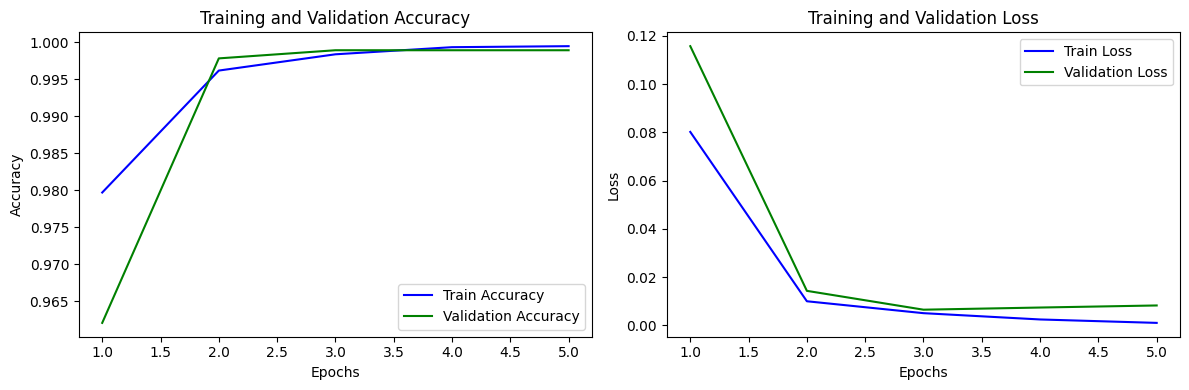

In [ ]:
train_acc = [t.item() for t in train_acc_history]
val_acc = [t.item() for t in val_acc_history]

# Eğitim istatistiklerini çiz
plot_training_stats(train_acc, val_acc, train_loss_history, val_loss_history)

In [ ]:
torch.save(model.state_dict(), '/content/gdrive/MyDrive/vgg16_pose_model2.pth')

In [ ]:
model.load_state_dict(torch.load('/content/gdrive/MyDrive/vgg16_pose_model2.pth'))
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
# Görüntüyü yükleme ve dönüştürme
image_path = '/content/gdrive/MyDrive/cas100082.png'
image = Image.open(image_path)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

input_image = transform(image).unsqueeze(0)  # Görüntüyü tensör formuna dönüştürme ve boyutunu genişletme


In [ ]:
# Görüntüyü CUDA cihazına gönderme (eğer kullanılıyorsa)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
input_image = input_image.to(device)

# Tahmin yapma
output = model(input_image)
_, predicted = torch.max(output, 1)

print("Tahmin Sonucu:")
print(class_names[predicted.item()])


Tahmin Sonucu:
fall
